In [1]:
# System imports
import os
import sys
sys.path.append("../")

# Standard imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Dataset imports
from tensorflow.keras.datasets import mnist

# Project library imports
from modules.deltavae.deltavae_latent_spaces import deltavae_sphere, deltavae_clifford_torus, deltavae_torus_r3, deltavae_o3, deltavae_so3, deltavae_o3, deltavae_rpd, stdvae
from modules.deltavae.deltavae_latent_spaces import deltavae_parameters
from modules.deltavae.encoder_decoder_architectures.encoder import encoder_dense
from modules.deltavae.encoder_decoder_architectures.decoder import decoder_dense
from modules.experiment_control import experiment_class, experiment_parameters
from modules.utils.data import dataset_creation

tf.config.experimental_run_functions_eagerly(True)


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


# Binary MNIST training
This notebook shows a sample script for the training of the $\Delta$VAE using the binary MNIST dataset. 

## Import MNIST dataset

In [2]:
# load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize images to [0,1]
x_train = dataset_creation.normalize_images(x_train)
x_test = dataset_creation.normalize_images(x_test)
# Binarize each pixel and add channel 
x_train = dataset_creation.binarize(x_train, 0)
x_test = dataset_creation.binarize(x_test, 0)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

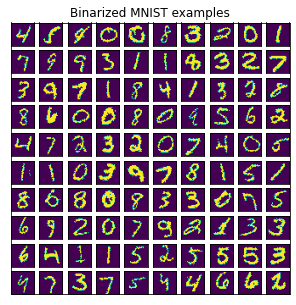

In [3]:
# Plot random binarized MNIST numbers
fig = plt.figure(figsize = (5,5))
plt.title("Binarized MNIST examples")
plt.xticks([])
plt.yticks([])

for i in range(100):
    ax = fig.add_subplot(10,10,i+1)
    ax.imshow(x_train[np.random.randint(0,len(x_train)),:,:,0])
    ax.set_xticks([])
    ax.set_yticks([])


## Parameters for training the $\Delta$VAE

Uncomment the manifold of your choice to train with the corresponding latent space. 

In [4]:
# Manifold choice 
# manifold = "hypersphere_d"
#manifold = "clifford_torus"
#manifold = "torus_r3"
#manifold = "o3"
#manifold = "so3"
#manifold = "rp_d"
manifold = "standard"

# Network parameters
H_DIM = 128 # Hidden state size
#if manifold == "hypersphere":
    
D = 2 # Latent space degrees of freedom
UNCONSTRAINED_T = True
BATCH_NORMALIZATION = False
CONTROLLED_CAPACITY = False
DECODER_OUTPUT_ACTIVATION = "sigmoid" # activation function for reconstruction


# Training parameters
EPOCHS = 100
BATCH_SIZE = 100

VAR_X = 1.0 
R_LOSS = "mse" # reconstruction loss


## Definition of network architecture

In [5]:
# # # # # # # # # # ENCODER # # # # # # # # # #
encoder_dict = {"input_shape": x_train.shape[1:],
                "unconstrained_t": UNCONSTRAINED_T,
                "dense_units_list":[H_DIM*2, H_DIM],
                "batch_normalization": BATCH_NORMALIZATION
                }
encoder_class = encoder_dense.EncoderDense(**encoder_dict)

# # # # # # # # # # DECODER # # # # # # # # # #
decoder_dict = {"input_shape": x_train.shape[1:],
                "dense_units_list":[H_DIM*2, H_DIM],
                "batch_normalization": BATCH_NORMALIZATION,
                "decoder_output_activation": DECODER_OUTPUT_ACTIVATION
                }
decoder_class = decoder_dense.DecoderDense(**decoder_dict)

# # # # # # # # # # Delta-VAE # # # # # # # # # #
vae_params_dict = {"d": D,
                   "var_x": VAR_X,
                   "controlled_capacity":CONTROLLED_CAPACITY,
                   "r_loss": R_LOSS,
                   "optimizer": tf.keras.optimizers.Adam()
                       }
diff_vae_params = deltavae_parameters.DiffusionVAEParams(**vae_params_dict)

# Build the appropriate DeltaVAE
if manifold == "hypersphere_d":
    vae = deltavae_sphere.DiffusionSphereVAE(diff_vae_params, encoder_class, decoder_class)
elif manifold == "clifford_torus":
    vae = deltavae_clifford_torus.DiffusionFlatTorusVAE(diff_vae_params, encoder_class, decoder_class)
elif manifold == "torus_r3":
    vae = deltavae_torus_r3.DiffusionTorusR3(diff_vae_params, encoder_class, decoder_class)
elif manifold == "o3":
    vae = deltavae_o3.DiffusionO3VAE(diff_vae_params, encoder_class, decoder_class)
elif manifold == "so3":
    vae = deltavae_so3.DiffusionSO3VAE(diff_vae_params, encoder_class, decoder_class)
elif manifold == "rp_d":
    vae = deltavae_rpd.DiffusionRPNVAE(diff_vae_params, encoder_class, decoder_class)
elif manifold == "standard":
    vae = stdvae.StandardVAE(diff_vae_params, encoder_class, decoder_class)
else:
    vae = None



Unconstrained time
Encoder built
Decoder built
Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      flatten[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256)          0           dense[0][0]                      
_____________________________________________

## Experiment definition and training

In [ ]:
########### EXPERIMENT CLASS ###########
# Experiment class
training_params_dict = {"epochs": EPOCHS,
                        "batch_size": BATCH_SIZE}
train_vae_params = experiment_parameters.ExperimentParams(**training_params_dict)
experiment_path = os.path.join(os.getcwd(), "results") # saving path for experiments
exp = experiment_class.Experiment(vae, train_vae_params, x_train, experiment_path)

# Start training
exp.run_vae()




/home/luis/diffusion_vae_v2/notebooks/results/tensorboard/2021-03-08-20-59_


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3356: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/100
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
600/600 - 125s - loss: 0.0000e+00 - kl_loss: 0.0000e+00 - r_loss: 818.5886 - mean_squared_error: 0.2504
Epoch 2/100


In [ ]:
__, ax = vae.save_plot_latent_space(x_test, y_test, 100 , None)
plt.title(r"Latent space embedding ")

In [ ]:
vae.save_plot_image_reconstruction(100, None, 10);
plt.title(r"Reconstruction of digit images")